In [ ]:
# default_exp learner

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *

# Learner

> Basic class for handling the training loop

## Gather the data

### MNIST

In [ ]:
from local.vision.core import *

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path, include=['train', 'valid'])
splits = GrandparentSplitter()(items)

In [ ]:
timg = Transform(Image.open, shows=partial(show_image, cmap="Greys", figsize=(2,2)))
tfms = [[timg,array,tensor,partial(torch.unsqueeze,dim=0)],
        [parent_label, Categorize(subset_idx=splits[0])]]
tfm = TfmOver.piped(tfms)
datasets = TfmdList(items, tfm)
# NB: `DataSource` is an easier way to handle this common case
train_ds,valid_ds = map(datasets.subset, splits)

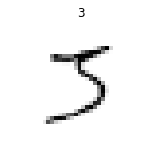

In [ ]:
train_ds.show_at(0)

In [ ]:
mean,std = (0.1307,0.3081)
dl_tfms = [ ByteToFloatTensor(), Normalize(mean,std)]
train_dl = TfmdDL(train_ds, dl_tfms, batch_size=64, shuffle=True)
valid_dl = TfmdDL(valid_ds, dl_tfms, batch_size=64)
mnist_data = DataBunch(train_dl, valid_dl)

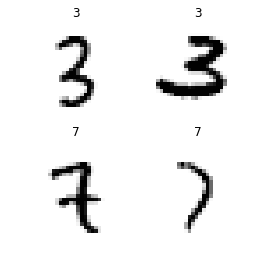

In [ ]:
_,axs = plt.subplots(2,2, figsize=(4,4))
x,y  = train_dl.one_batch()
train_dl.show_batch((x,y), ctxs=axs.flatten(), max_rows=4)

### Synthetic data

In [ ]:
from torch.utils.data import TensorDataset

def synth_data(a=2, b=3, bs=16, n_trn=10, n_val=2):
    x_trn = torch.randn(bs*n_trn)
    y_trn = a*x_trn + b + 0.1*torch.randn(bs*n_trn)
    x_val = torch.randn(bs*n_val)
    y_val = a*x_val + b + 0.1*torch.randn(bs*n_val)
    train_ds = TensorDataset(x_trn, y_trn)
    valid_ds = TensorDataset(x_val, y_val)
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True)
    valid_dl = TfmdDL(valid_ds, bs=bs)
    return DataBunch(train_dl, valid_dl)

In [ ]:
class RegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1).squeeze()),nn.Parameter(torch.randn(1).squeeze())
    def forward(self, x): return x * self.a + self.b

## Callback - 

In [ ]:
#export
class Callback():
    order=0
    def set_learner(self, learn): self.learn=learn
    def __getattr__(self, k):     return getattr(self.learn, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [ ]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.learn.n_epochs=0.
        self.learn.n_iter=0
        
    def begin_batch(self):
        if self.learn.n_iter == 0: self.model.to(find_device(self.xb))
    
    def after_batch(self):
        if not self.in_train: return
        self.learn.n_epochs += 1./self.iters
        self.learn.n_iter   += 1
        
    def begin_epoch(self):
        self.learn.n_epochs=self.epoch
        self.model.train()
        self.learn.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.learn.in_train=False

In [ ]:
#export
class CancelFitException  (Exception): pass
class CancelEpochException(Exception): pass
class CancelTrainException(Exception): pass
class CancelValidException(Exception): pass
class CancelBatchException(Exception): pass

## Learner -

In [ ]:
# export
def trainable_params(m): 
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [ ]:
#export core
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [ ]:
test_eq(camel2snake('ClassAreCamel'), 'class_are_camel')

In [ ]:
# export
event = SimpleNamespace(**{o:o for o in {
    'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_cancel_batch', 
    'after_batch', 'after_cancel_epoch', 'begin_fit', 'begin_epoch', 'begin_epoch', 'begin_validate', 
    'after_epoch', 'after_cancel_train', 'after_fit'
}})

In [ ]:
# export
class Learner():
    def __init__(self, model, data, loss_func, opt_func=SGD, lr=1e-2, splitter=trainable_params,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func = model,data,loss_func
        self.opt_func,self.lr,self.splitter = opt_func,lr,splitter
        
        self.in_train,self.logger,self.opt = False,print,None
        self.cbs = L([])
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in L(cb_funcs))

    def add_cbs(self, cbs):
        for cb in L(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in L(cbs): self.remove_cb(cb)
            
    def remove_cb(self, cb):
        cb.learn = None
        setattr(self, cb.name, None)
        self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelTrainException: self('after_cancel_train')
        except CancelValidException: self('after_cancel_valid')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                try:
                    self.do_begin_epoch(epoch)
                    self.all_batches()
                    with torch.no_grad(): 
                        self.dl = self.data.valid_dl
                        self.all_batches()
                except CancelEpochException: self('after_cancel_epoch')
                finally:                     self('after_epoch')
            
        except CancelFitException: self('after_cancel_fit')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    def __call__(self, cb_name):
        res = False
        assert hasattr(event, cb_name)
        for cb in self.cbs.sorted("order"): res = cb(cb_name) and res
        return res

In [ ]:
def synth_learner(n_trn=10, n_val=2, **kwargs):
    return Learner(RegModel(), synth_data(n_trn=n_trn,n_val=n_val), MSELossFlat(), **kwargs)
learn = synth_learner()
learn.fit(1)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#export
class VerboseCallback(Callback):
    def __call__(self, cb_name):
        print(cb_name)
        super().__call__(cb_name)

In [ ]:
class TestCancelBatchCallback(VerboseCallback):
    def __init__(self, cancel_at=event.begin_batch):
        def _interrupt():
            if self.in_train: raise CancelBatchException()
        setattr(self, cancel_at, _interrupt)
    
    def after_cancel_batch(self): print(f'Batch {self.n_iter} cancelled')

In [ ]:
learn = synth_learner(n_trn=1, n_val=0)
learn.fit(1, cbs=TestCancelBatchCallback())

begin_fit
begin_epoch
begin_batch
after_cancel_batch
Batch 0 cancelled
after_batch
after_epoch
after_fit


In [ ]:
event.begin_batch

'begin_batch'